# Clase Regresión Logística en Phyton
#### Tiempo de lectura 20 minutos

La base de datos que se va a utilizar fue obtenida de Kaggle; contiene transacciones hechas con tarjeta de crédito, asi mismo tiene una marca que indica que transacciones fueron fraude y cuales no, aqui es dónde participa la regresión lógistica prediciendo que transacciones son legitimas. Para más información del data set consulta [aquí](https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud)

## Tres pasos:
1. Análisis inicial de la base de datos
1. Análisis exploratorio con gráficos
1. Desarrollo y validación de la RL

## 1. Análisis inicial de la base de datos

In [ ]:
# Librerias necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.metrics import jaccard_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [ ]:
# Se consulta la base de datos
df_fraudes=pd.read_csv('C:/Users/Héctor/OneDrive/Data Scientist/Proyecto_portafolio/proyecto-portafolio/Data/card_transdata.csv',delimiter=',')

#### Siempre resulta útil dar un primer vistazo al data set 

In [12]:
df_fraudes.head(10)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
5,5.586408,13.261073,0.064768,1.0,0.0,0.0,0.0,0.0
6,3.724019,0.956838,0.278465,1.0,0.0,0.0,1.0,0.0
7,4.848247,0.320735,1.273050,1.0,0.0,1.0,0.0,0.0
8,0.876632,2.503609,1.516999,0.0,0.0,0.0,0.0,0.0
9,8.839047,2.970512,2.361683,1.0,0.0,0.0,1.0,0.0


#### Se observa que todas las variables son númericas, las primeras tres variables toman valores continuos y a partir de repeat_retailer parece que son binarias, contiene 8 columnas
#### Pero ¿Cuántos renglones contiene?

In [13]:
#Cuantos renglones y columnas tiene
df_fraudes.shape

(1000000, 8)

Con esto se observa que tiene un millón de renglones y 8 columnas

### Saber si la base de datos tiene renglones duplicados es también una buena práctica

In [54]:
df_fraudes_sin_duplicados = df_fraudes.drop_duplicates()
df_fraudes_sin_duplicados.shape

(1000000, 8)

La base no tiene duplicados, dado que la base sin duplicados y la original tienen el mismo número de registros

## 2. Análisis exploratorio con gráficos

#### Un análisis rápido de las variables

In [55]:
#Tiene missings, minimos, maximos, medias, desviación estandar
df_fraudes.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


    Algo importante a notar aquí es que todas las variables tienen un millón en el conteo, eso indica que ninguna variable tiene registros vacios
    Para las tres primeras variables que son continuas se deja al lector la interpretación de la media, desviasión estandar y demas métricas contenidas

### Una regresión lógistica requiere de dos tipos de variables.
1. Variable objetivo: también llamada dependiente, en este caso la variable objetivo es fraud
1. Variables independientes: en este caso puede ser una o todas las demas dependiendo de la correlación que tengan con la variable objetivo

### Dicho esto, todo el análisis exploratorio debe girar en torno a la correlación que exista entre las variables independientes y la dependiente (fraud)

#### Pero, cuantas transacciones, del millón que contiene la base, fueron marcadas como fraude

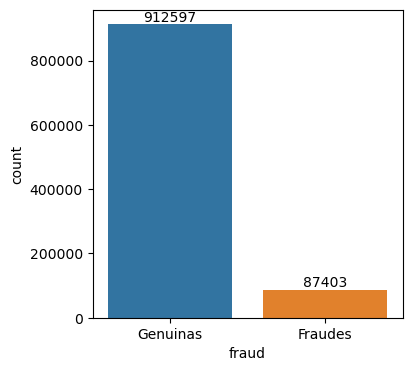

In [15]:
plt.figure(figsize=(4,4))

ax1=sb.countplot(x="fraud", data=df_fraudes)
for label in ax1.containers:
    ax1.bar_label(label)
    ax1.set_xticklabels(['Genuinas','Fraudes'])
plt.show()

Aproximadamente el 8.7% de las observaciones fueron marcadas como fraude

### Ahora se graficarán las variables continuas considerando la variable objetivo

#### Para hacer comparables las variables continuas se obtiene el logaritmo base 10, esto también ayuda a tener más cercanos los datos

<Figure size 2000x1000 with 0 Axes>

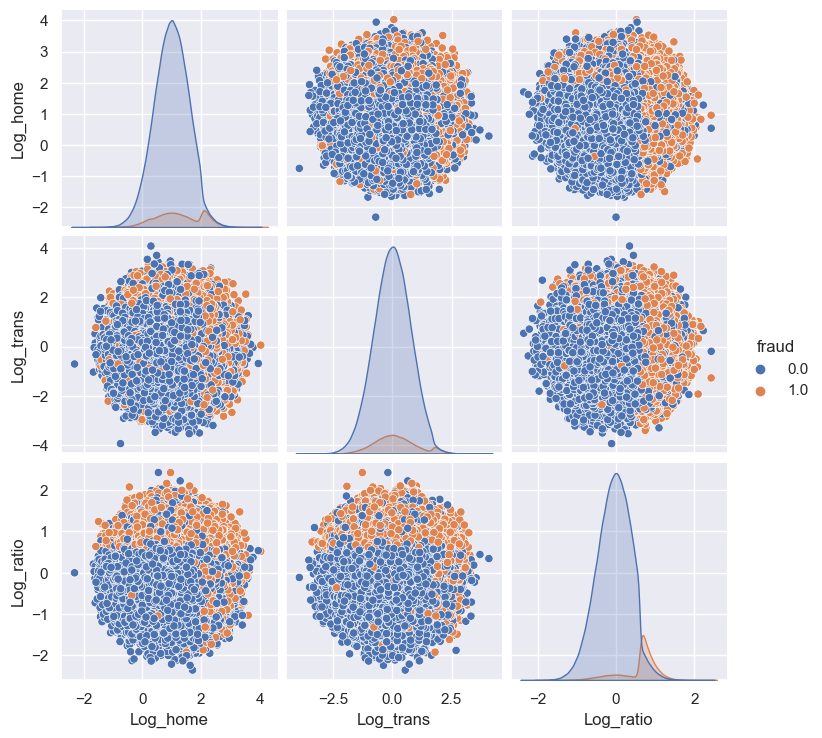

In [26]:
df_fraudes['Log_home'] = np.log10(df_fraudes['distance_from_home'])
df_fraudes['Log_trans'] = np.log10(df_fraudes['distance_from_last_transaction'])
df_fraudes['Log_ratio'] = np.log10(df_fraudes['ratio_to_median_purchase_price'])

sb.pairplot(data=df_fraudes[['Log_home','Log_trans','Log_ratio','fraud']], hue = 'fraud')
plt.show()

Para las variables de distancia, desde casa y desde la última transacción no parece haber mucha correlación, pero la variable de ratio después de cierto punto tiene mucho fraude, por lo que será conveniente hacer más análisis sobre esta variable

#### Se crean deciles de la variable de ratio, para graficarlos y entender la correlación

In [20]:
df_ratio=df_fraudes[['ratio_to_median_purchase_price', 'fraud']]
df_ratio['Rangos_ratio'] = pd.qcut(df_ratio['ratio_to_median_purchase_price'], q=10)

C:\Users\Héctor\AppData\Local\Temp\ipykernel_21008\2783388598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratio['Rangos_ratio'] = pd.qcut(df_ratio['ratio_to_median_purchase_price'], q=10)


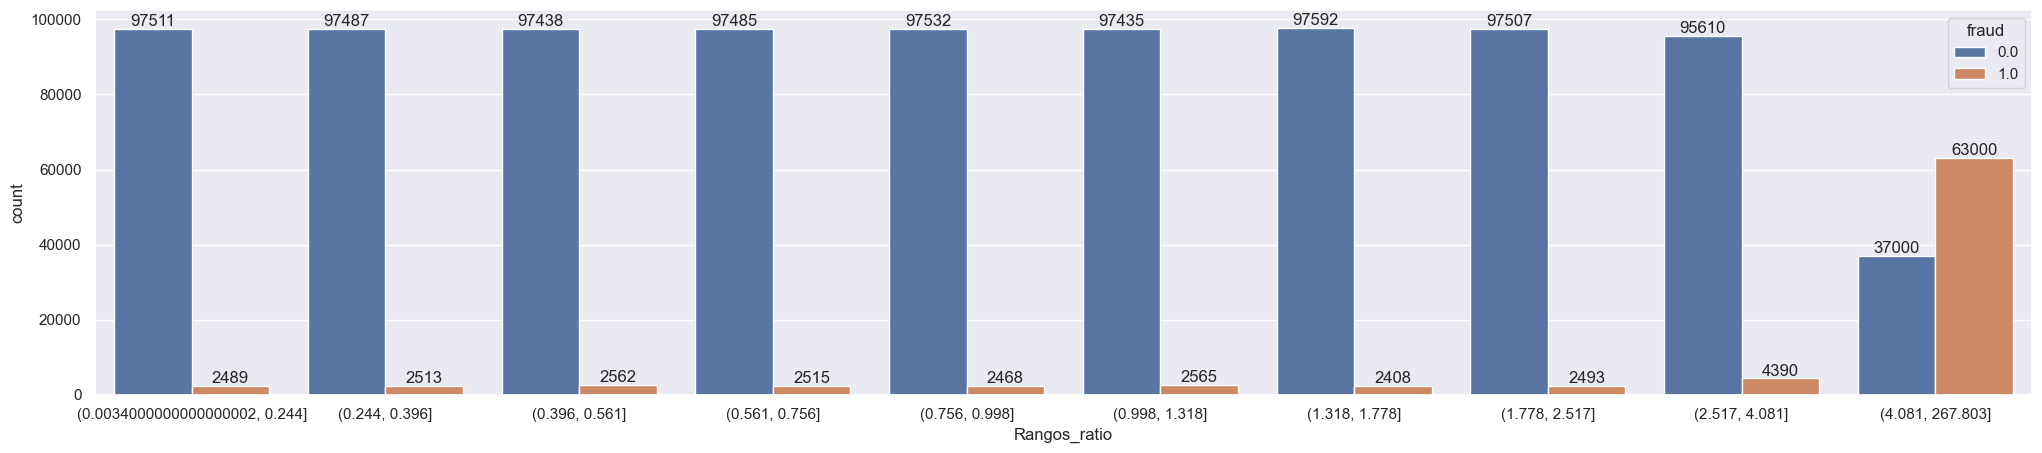

In [29]:
plt.figure(figsize=(25, 5))
ax = sb.countplot(x="Rangos_ratio", data=df_ratio, hue="fraud" )
for label in ax.containers:
    ax.bar_label(label)
plt.show()

##### Con esto se aprecia que aquellas transacciones con un ratio de 4 o mas tienen el 72% de todo lo marcado como fraude

#### Ahora veamos la correlación que existe con las variables binarias

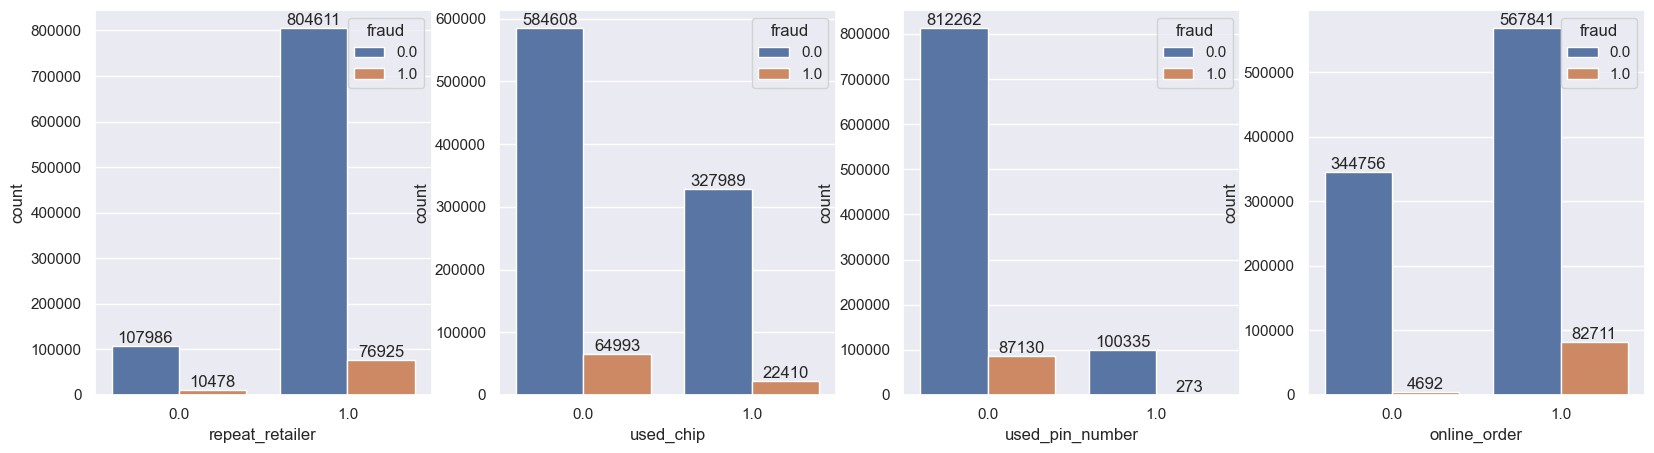

<Figure size 300x400 with 0 Axes>

<Figure size 300x400 with 0 Axes>

<Figure size 300x400 with 0 Axes>

<Figure size 300x400 with 0 Axes>

In [28]:
variables_binarias = ['repeat_retailer', 'used_chip','used_pin_number', 'online_order']
fig,ax = plt.subplots(1,4,figsize=(20,5))

for i,col in enumerate(variables_binarias):
    plt.figure(figsize=(3,4))
    ax[i]=sb.countplot(x=col, data=df_fraudes, hue="fraud", ax=ax[i])
    for label in ax[i].containers:
        ax[i].bar_label(label)

#### Viendo estás gráficas se podría inferir que las transacciones con chip y pin son ligeramente más seguras y también que las transacciones en línea tienden a tener más fraude que las que no son en línea

### Para terminar el análisis exploratorio se hace un mapa de calor que indica las correlaciones, esto puede fortalecer los primeros hallazgos o refutarlos

<Axes: >

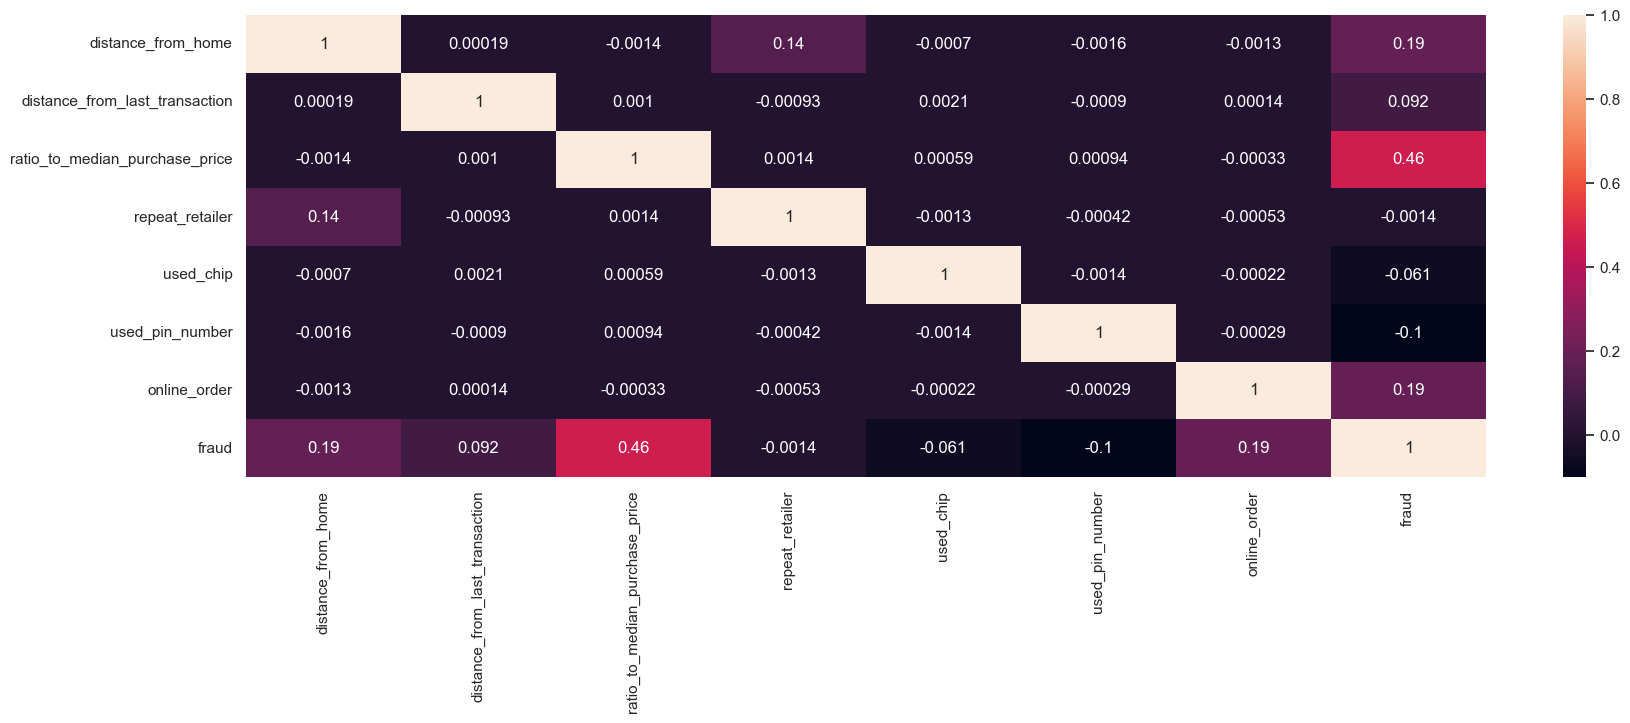

In [25]:
sb.set(rc = {"figure.figsize":(20, 6)}) #graph size
corr = df_fraudes.corr()
sb.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap = "rocket") #viridis, rocket, rocket_r, hot entre otras son las mejores paletas de colores para este caso

### Con este mapa de calor se nota que:
1. La variable de ratio si es la que tiene la mayor correlación
1. La variable de online order si presenta una buena correlación
1. La variable de distancia desde casa también tiene una correlación importante y se estaba quedando fuera solo con el análisis anterior

# 3. Desarrollo y validación de la Regresión Logística

Se crea una variable X que contendrá las variables independientes

In [77]:
X = np.asarray(df_fraudes[['distance_from_home', 'ratio_to_median_purchase_price', 'used_pin_number', 'online_order']])
X[0:5]

array([[57.88,  1.95,  0.  ,  0.  ],
       [10.83,  1.29,  0.  ,  0.  ],
       [ 5.09,  0.43,  0.  ,  1.  ],
       [ 2.25,  0.36,  0.  ,  1.  ],
       [44.19,  2.22,  0.  ,  1.  ]])

Ahora se crea la variable independiente

Se estandirzan las variables incependientes, esto se hace por que variables con valores más altos pueden influir más en el modelo, de esta manera todas las variables están en terminos similares

In [78]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.48,  0.04, -0.33, -1.36],
       [-0.24, -0.19, -0.33, -1.36],
       [-0.33, -0.5 , -0.33,  0.73],
       [-0.37, -0.52, -0.33,  0.73],
       [ 0.27,  0.14, -0.33,  0.73]])

In [79]:
y = np.asarray(df_fraudes['fraud'])
y [0:5]

array([0., 0., 0., 0., 0.])

Se separa el conjunto de datos entre entrenamiento y test

In [80]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (800000, 4) (800000,)
Test set: (200000, 4) (200000,)


El conjunto de entrenamiento contiene el 80% de los datos y el de test el 20%

Se entrena la Regresión Logística

In [81]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

### Una regresión logistica arroja una probabilidad de que el resultado sea 1 y una probabilidad de que sea cero
### Hecho eso, se asigna el número 1 o 0 según sea mayor la probabilidad

#### Se utiliza la regresión entrenada para que arroje las probabilidades

In [82]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[1.00e+00, 9.07e-05],
       [9.99e-01, 5.11e-04],
       [9.63e-01, 3.66e-02],
       ...,
       [9.70e-01, 3.00e-02],
       [4.54e-04, 1.00e+00],
       [1.00e+00, 1.06e-04]])

Son dos columnas por que una indica la probabilidad de que sea cero ese registro y el otra columna indica la probabilidad de que sea uno

Sin embargo, también se puede obtener directamente el resultado de uno o cero

In [83]:
yhat = LR.predict(X_test)
yhat

array([0., 0., 0., ..., 0., 1., 0.])

Se podría ver la tabla con una columna de Fraud real y una de Fraud Predict, pero es más útil ver una matriz de confusión de cuantos casos se predijeron de manera correcta

In [84]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, with normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[  9445   7938]
 [  1234 181383]]


Confusion matrix, with normalization
[[  9445   7938]
 [  1234 181383]]


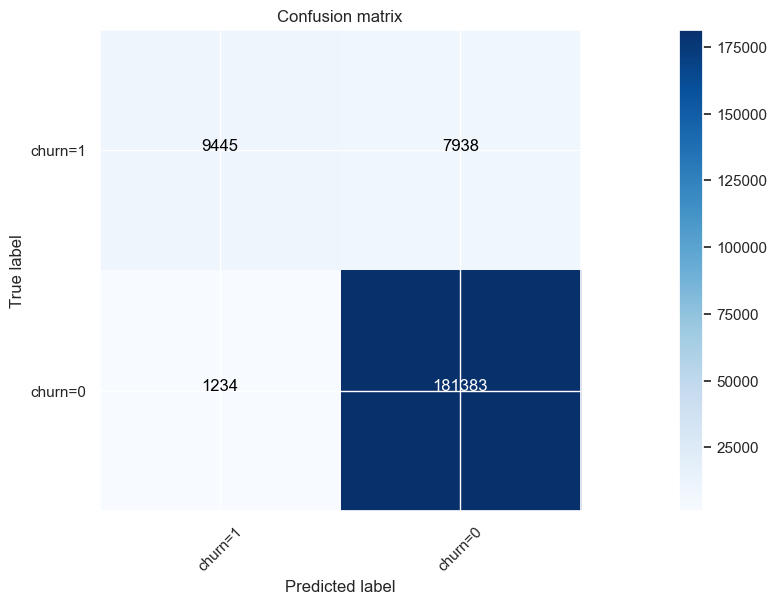

In [85]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

### En esta matriz de confusión vale la pena dedicar algunas líneas, puesto que indica que tan bien o mal esta el modelo prediciendo:

1. Se tienen 181,281 casos marcados como 0 y que efectivamente eran 0. 
    1. De todos los casos que eran efectivamente cero (181,383 + 1,234 = 182,617) el 99% (181,383 / 182,617) fue correctamente predecido -> Esta métrica es conocida como calidad
    1. De todos los casos que el modelo marco como 0 (7,938 + 181,383 = 189,321) el 96% (181,383 / 189,3833) eran efectivamente cero -> Esta métrica es conocida como precisión
1. Se tienen 8,591 casos marcados como 1 y que efectivamente eran 1.
    1. De todos los casos que eran efectivamente uno (9,445 + 7,938 =  17,383) el 54% (8,591 / 17,383) fue correctamente predecido
    1. De todos los casos que el modelo marco como 1 (9,445 + 1,234 = 10,679) el 88% (10,679 / 10,679) eran efectivamente uno

### Todo esto se puede observar en el siguiente reporte que se obtiene de directamente de Python

In [86]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98    182617
         1.0       0.88      0.54      0.67     17383

    accuracy                           0.95    200000
   macro avg       0.92      0.77      0.82    200000
weighted avg       0.95      0.95      0.95    200000



F1 Score es una combinación de la precisión y la calidad, indica con que tanta certeza el modelo esta funcionando, se puede decir que en general el modelo tiene un 94% de certeza

Otro Score a considerar es el Jaccard Score, y se puede obtener de la siguiente manera

In [87]:
jaccard_score(y_test, yhat,pos_label=0)

0.9518669150638923

94% como se observa es muy parecido, en este caso, al f1-score

In [88]:
LR.coef_[0]

array([ 0.85,  2.12, -2.78,  2.59])

### Como última validación del modelo, se revisa cuanto peso tienen las variables independientes en el resultado de la predicción

In [94]:
def get_feature_importance (LR, feature_names):
    feature_importance = (
        pd.DataFrame(
            {
                'Variable': feature_names,
                'Coeficiente': LR.coef_[0]
            }
        )
        .round(decimals=2) \
        .sort_values('Coeficiente', ascending=False) \
        .style.bar(color=['red', 'green'], align='zero')
    )
    return feature_importance

In [95]:
get_feature_importance(LR, ['distance_from_home', 'ratio_to_median_purchase_price', 'used_pin_number', 'online_order'])

,Variable,Coeficiente
3,online_order,2.590000
1,ratio_to_median_purchase_price,2.120000
0,distance_from_home,0.850000
2,used_pin_number,-2.780000


Resulta que la variable que tiene más peso en el modelo es si el cliente utilizó o no el pin number seguida de la compra en línea, también el ratio resulta importante, la distancia desde casa es la variable que menos importancia tiene en el modelo 

# Conclusiones:
1. Se realizo el análisis inicial de la base de datos, es una base muy limpia, sin missings ni duplicados
1. El análisis exploratorio utilizando principalmente la libreria de seaborn que resultó muy poderosa para darnos información de manera gráfica de las variables
1. Una Regresión Logística fue entrenada y validada con un poder predictivo de 95%

De aqui en adelante es solo respaldo del código utilizado durante el análisis y varios intentos, gráficos y demas que se fueron perfeccionando durante el análisis

In [ ]:
df_fraudes.columns

In [ ]:
sb.pairplot(df_fraudes)

<Axes: ylabel='Feature'>

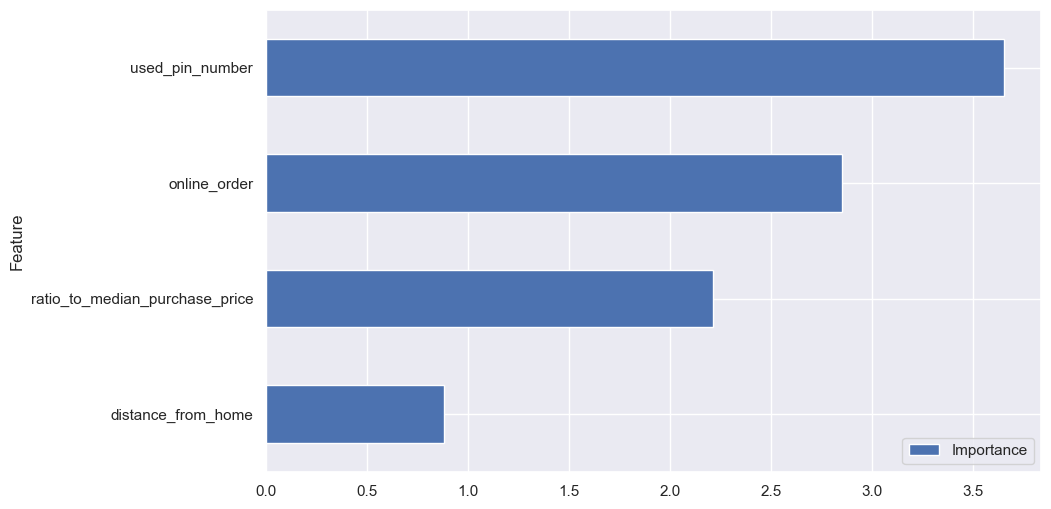

In [66]:
X = df_fraudes.drop(['fraud', 'distance_from_last_transaction', 'repeat_retailer', 'used_chip', 'Log_ratio', 'Log_home', 'Log_trans'], axis=1)
y = df_fraudes['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)

coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [67]:
print(coefficients)

[ 0.88  2.21 -3.66  2.85]


In [7]:
#Agrupando datos por genero y contando
df_f=df_fraudes[['fraud', 'used_chip']]
df_f_count=df_f.groupby(['fraud']).count()
df_f_count=df_f_count.rename(columns={'used_chip':'count'})
df_f_count

,count
fraud,
0.0,912597
1.0,87403


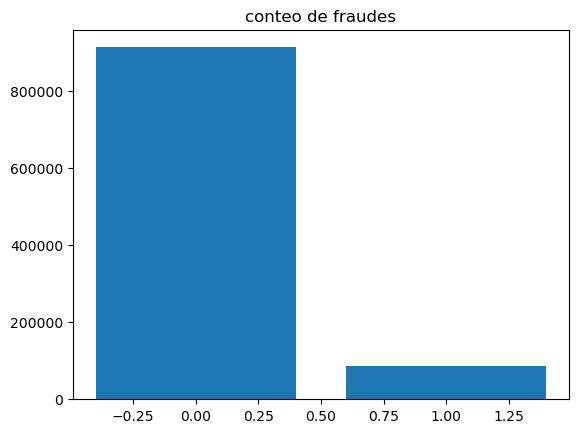

In [8]:
#hacer conteo por edad
plt.bar(df_f_count.index, df_f_count['count'])
plt.title('conteo de fraudes')
plt.show()

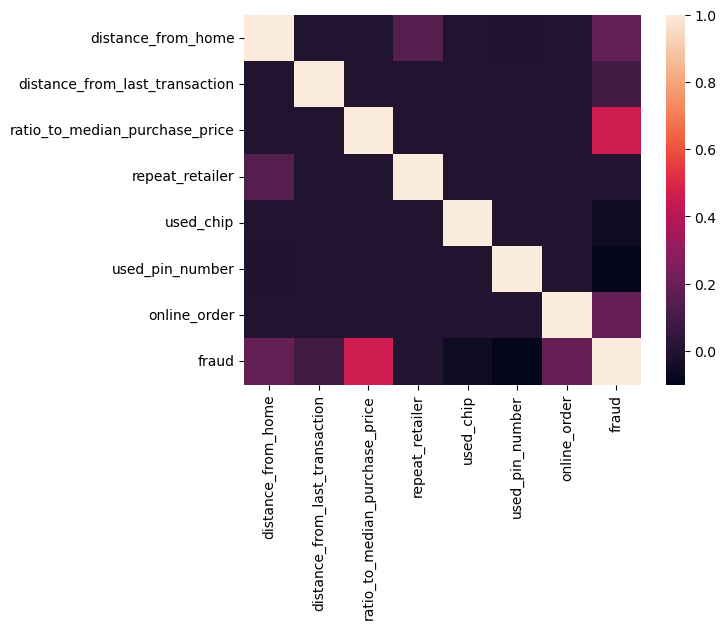

In [10]:
# graficando las correlaciones
dataplot=sb.heatmap(df_fraudes.corr())
  
# mostrando el mapa de calor
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

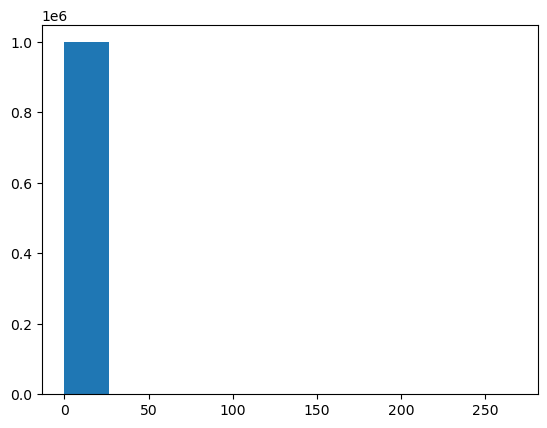

In [11]:
#El ratio es importante por que esta muy correlacionado a la variable de interes
#hacer histograma de edad
df_ratio=df_fraudes[['ratio_to_median_purchase_price', 'fraud']]
plt.hist(df_ratio['ratio_to_median_purchase_price'])
plt.show

In [12]:
#Crear deciles de la variable para que nos deje ver algo más
df_ratio['Rangos_ratio'] = pd.qcut(df_ratio['ratio_to_median_purchase_price'], q=10)
df_ratio.head()

C:\Users\Héctor\AppData\Local\Temp\ipykernel_2136\2614463904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratio['Rangos_ratio'] = pd.qcut(df_ratio['ratio_to_median_purchase_price'], q=10)


,ratio_to_median_purchase_price,fraud,Rangos_ratio
0,1.945940,0.0,"(1.778, 2.517]"
1,1.294219,0.0,"(0.998, 1.318]"
2,0.427715,0.0,"(0.396, 0.561]"
3,0.362663,0.0,"(0.244, 0.396]"
4,2.222767,0.0,"(1.778, 2.517]"


In [13]:
df_ratio_count=df_ratio.groupby(['Rangos_ratio','fraud']).count()
df_ratio_count

ratio_to_median_purchase_price
Rangos_ratio                   fraud                                
(0.0034000000000000002, 0.244] 0.0                             97511
                               1.0                              2489
(0.244, 0.396]                 0.0                             97487
                               1.0                              2513
(0.396, 0.561]                 0.0                             97438
                               1.0                              2562
(0.561, 0.756]                 0.0                             97485
                               1.0                              2515
(0.756, 0.998]                 0.0                             97532
                               1.0                              2468
(0.998, 1.318]                 0.0                             97435
                               1.0                              2565
(1.318, 1.778]                 0.0                             97592
                               1.0                              2408
(1.778, 2.517]                 0.0                             97507
                               1.0                              2493
(2.517, 4.081]                 0.0                             95610
                               1.0                              4390
(4.081, 267.803]               0.0                             37000
                               1.0                             63000

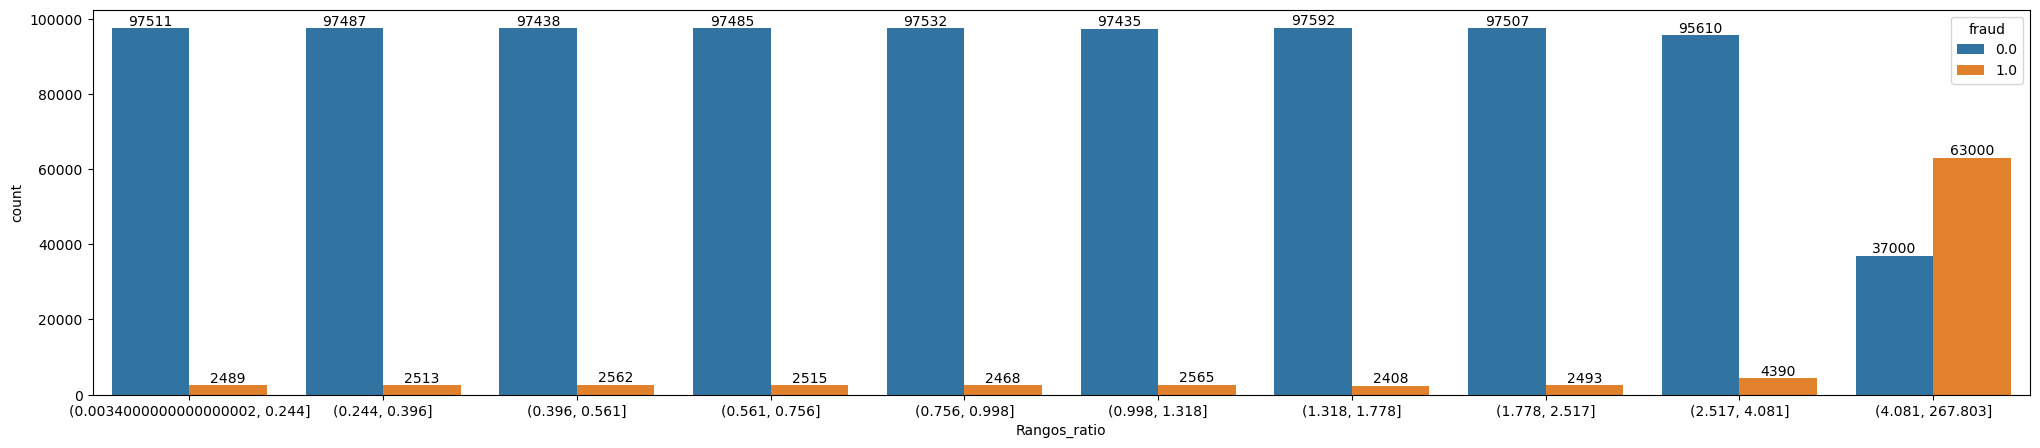

In [14]:
# Set the figure size
plt.figure(figsize=(25, 5))

# grouped barplot
ax = sb.countplot(x="Rangos_ratio", data=df_ratio, hue="fraud" )
for label in ax.containers:
    ax.bar_label(label)
plt.show()

In [15]:
#Primer finding: De los 87,403 fraudes que hay, 63,000(el 72%) tienen un ratio mayor a 4.081

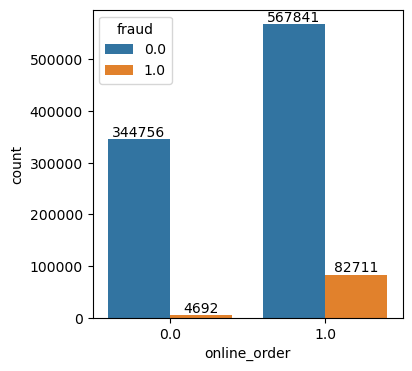

In [26]:
#Más gráficas de conteos: repeat_retailer used_chip used_pin_number online_order

plt.figure(figsize=(4,4))

ax1=sb.countplot(x="online_order", data=df_fraudes, hue="fraud")
for label in ax1.containers:
    ax1.bar_label(label)
plt.show()

In [17]:
df_fraudes.corr()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
distance_from_home,1.000000,0.000193,-0.001374,0.143124,-0.000697,-0.001622,-0.001301,0.187571
distance_from_last_transaction,0.000193,1.000000,0.001013,-0.000928,0.002055,-0.000899,0.000141,0.091917
ratio_to_median_purchase_price,-0.001374,0.001013,1.000000,0.001374,0.000587,0.000942,-0.000330,0.462305
repeat_retailer,0.143124,-0.000928,0.001374,1.000000,-0.001345,-0.000417,-0.000532,-0.001357
used_chip,-0.000697,0.002055,0.000587,-0.001345,1.000000,-0.001393,-0.000219,-0.060975
used_pin_number,-0.001622,-0.000899,0.000942,-0.000417,-0.001393,1.000000,-0.000291,-0.100293
online_order,-0.001301,0.000141,-0.000330,-0.000532,-0.000219,-0.000291,1.000000,0.191973
fraud,0.187571,0.091917,0.462305,-0.001357,-0.060975,-0.100293,0.191973,1.000000


In [19]:
# Crear columnas condicionalmente
condiciones = [((df_fraudes['used_chip'] == 1) & (df_fraudes['used_pin_number'] == 1)),
               -((df_fraudes['used_chip'] == 1) & (df_fraudes['used_pin_number'] == 1))
        ]

opciones = [1,0]

#incluir condiciones y opciones
df_fraudes['doble_factor'] = np.select(condiciones,opciones)

In [20]:
condiciones = [((df_fraudes['used_chip'] == 1) & (df_fraudes['online_order'] == 0)),
               -((df_fraudes['used_chip'] == 1) & (df_fraudes['online_order'] == 0))
        ]

opciones = [1,0]

#incluir condiciones y opciones
df_fraudes['tarjeta_presente'] = np.select(condiciones,opciones)

In [21]:
df_fraudes[['used_chip', 'used_pin_number', 'doble_factor', 'tarjeta_presente']]

,used_chip,used_pin_number,doble_factor,tarjeta_presente
0,1.0,0.0,0,1
1,0.0,0.0,0,0
2,0.0,0.0,0,0
3,1.0,0.0,0,0
4,1.0,0.0,0,0
...,...,...,...,...
999995,1.0,0.0,0,1
999996,1.0,0.0,0,1
999997,1.0,0.0,0,0
999998,0.0,0.0,0,0


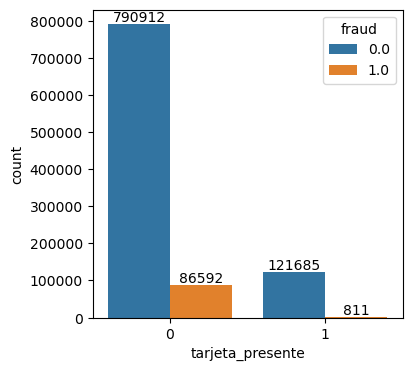

In [22]:
plt.figure(figsize=(4,4))

ax1=sb.countplot(x="tarjeta_presente", data=df_fraudes, hue="fraud")
for label in ax1.containers:
    ax1.bar_label(label)
plt.show()

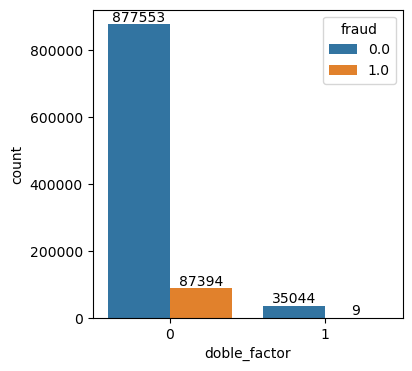

In [23]:
plt.figure(figsize=(4,4))

ax1=sb.countplot(x="doble_factor", data=df_fraudes, hue="fraud")
for label in ax1.containers:
    ax1.bar_label(label)
plt.show()

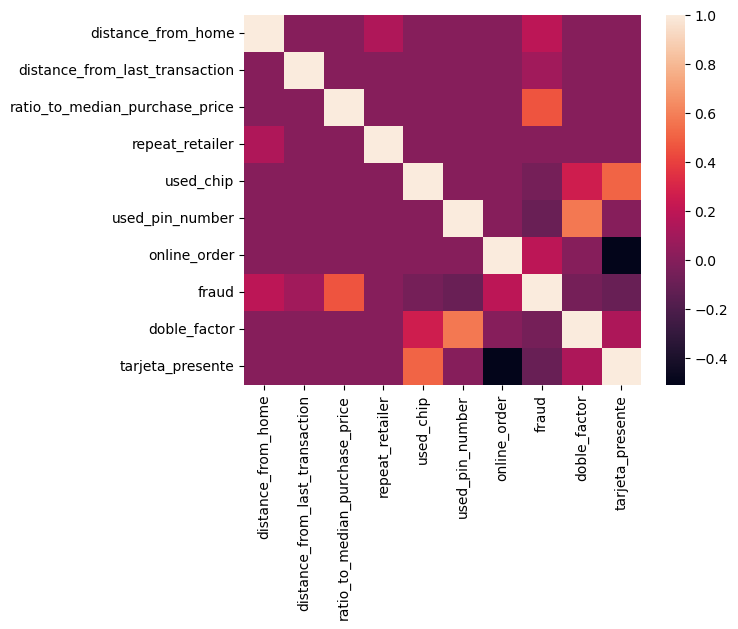

In [24]:
# graficando las correlaciones
dataplot=sb.heatmap(df_fraudes.corr())
  
# mostrando el mapa de calor
plt.show()

In [25]:
df_fraudes.corr()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,doble_factor,tarjeta_presente
distance_from_home,1.000000,0.000193,-0.001374,0.143124,-0.000697,-0.001622,-0.001301,0.187571,-0.000708,-0.000528
distance_from_last_transaction,0.000193,1.000000,0.001013,-0.000928,0.002055,-0.000899,0.000141,0.091917,0.000378,-0.000487
ratio_to_median_purchase_price,-0.001374,0.001013,1.000000,0.001374,0.000587,0.000942,-0.000330,0.462305,0.002015,0.001560
repeat_retailer,0.143124,-0.000928,0.001374,1.000000,-0.001345,-0.000417,-0.000532,-0.001357,-0.002094,-0.001507
used_chip,-0.000697,0.002055,0.000587,-0.001345,1.000000,-0.001393,-0.000219,-0.060975,0.259509,0.508719
used_pin_number,-0.001622,-0.000899,0.000942,-0.000417,-0.001393,1.000000,-0.000291,-0.100293,0.569861,0.000476
online_order,-0.001301,0.000141,-0.000330,-0.000532,-0.000219,-0.000291,1.000000,0.191973,-0.001389,-0.509784
fraud,0.187571,0.091917,0.462305,-0.001357,-0.060975,-0.100293,0.191973,1.000000,-0.058811,-0.106869
doble_factor,-0.000708,0.000378,0.002015,-0.002094,0.259509,0.569861,-0.001389,-0.058811,1.000000,0.133955
tarjeta_presente,-0.000528,-0.000487,0.001560,-0.001507,0.508719,0.000476,-0.509784,-0.106869,0.133955,1.000000


<Axes: xlabel='distance_from_home', ylabel='fraud'>

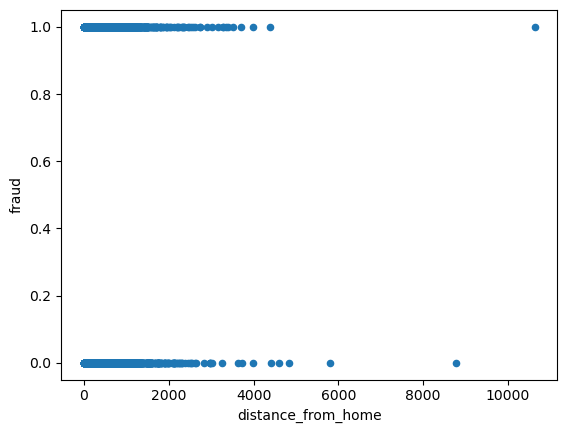

In [26]:
df_fraudes[['distance_from_home','fraud']].plot.scatter(x='distance_from_home',y='fraud')

In [27]:
X = np.asarray(df_fraudes[['distance_from_home', 'ratio_to_median_purchase_price', 'used_pin_number', 'online_order']])
X[0:5]

array([[57.87785658,  1.94593998,  0.        ,  0.        ],
       [10.8299427 ,  1.29421881,  0.        ,  0.        ],
       [ 5.09107949,  0.42771456,  0.        ,  1.        ],
       [ 2.24756433,  0.36266258,  0.        ,  1.        ],
       [44.190936  ,  2.2227673 ,  0.        ,  1.        ]])

In [28]:
y = np.asarray(df_fraudes['fraud'])
y [0:5]

array([0., 0., 0., 0., 0.])

In [29]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.47788202,  0.04349141, -0.33445812, -1.36442519],
       [-0.24160679, -0.18930045, -0.33445812, -1.36442519],
       [-0.3293694 , -0.49881185, -0.33445812,  0.73290937],
       [-0.37285438, -0.52204812, -0.33445812,  0.73290937],
       [ 0.26857229,  0.14237287, -0.33445812,  0.73290937]])

In [30]:

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (800000, 4) (800000,)
Test set: (200000, 4) (200000,)


In [31]:

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [32]:
yhat = LR.predict(X_test)
yhat

array([0., 0., 0., ..., 0., 1., 0.])

In [33]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[9.99909260e-01, 9.07398806e-05],
       [9.99489212e-01, 5.10788097e-04],
       [9.63429160e-01, 3.65708397e-02],
       ...,
       [9.70025888e-01, 2.99741117e-02],
       [4.53972085e-04, 9.99546028e-01],
       [9.99893676e-01, 1.06324053e-04]])

In [34]:

jaccard_score(y_test, yhat,pos_label=0)

0.9518669150638923

In [35]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[  9445   7938]
 [  1234 181383]]


Confusion matrix, without normalization
[[  9445   7938]
 [  1234 181383]]


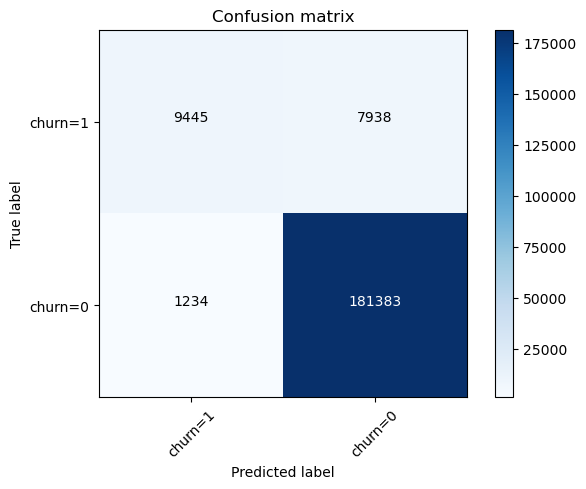

In [36]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

In [56]:
X = df_fraudes.drop('fraud','distance_from', axis=1)
y = df_fraudes['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

C:\Users\Héctor\AppData\Local\Temp\ipykernel_21008\2289515780.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_fraudes.drop('fraud','distance_from')


ValueError: No axis named distance_from for object type DataFrame

In [42]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)

coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
yhat=model.predict(X_test)
yhat

In [39]:
jaccard_score(y_test, yhat,pos_label=0)

0.9518669150638923

In [40]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98    182617
         1.0       0.88      0.54      0.67     17383

    accuracy                           0.95    200000
   macro avg       0.92      0.77      0.82    200000
weighted avg       0.95      0.95      0.95    200000



<Axes: >

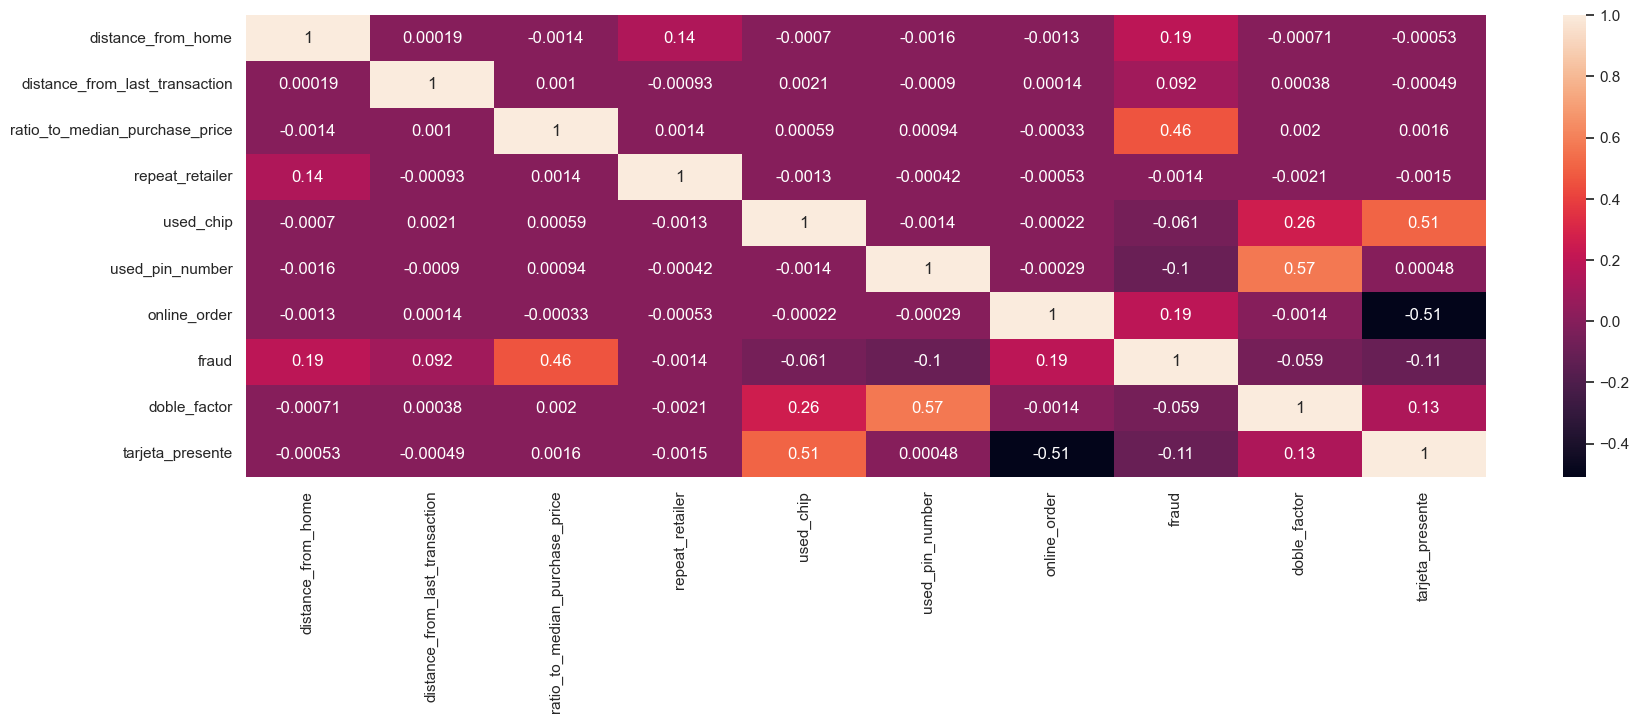

In [41]:
sb.set(rc = {"figure.figsize":(20, 6)}) #graph size
corr = df_fraudes.corr()
sb.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap = "rocket") #viridis, rocket, rocket_r, hot entre otras son las mejores paletas de colores para este caso